<a href="https://colab.research.google.com/github/jresendiz27/xss_sqli_detector/blob/main/00_01_CreatingFeatures_XSS_SQLi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starting the Feature Creation (dataset level)

### Now, let's start creating some features!
We will take some inspiration on the OWASP coreruleset repository for diagnosing XSS and SQLi injection attacks
They provide some configurations for apache just as a plug-n-play and reject requests based on certain regexes.
* [Corerules XSS configurations](https://github.com/coreruleset/coreruleset/blob/main/rules/REQUEST-941-APPLICATION-ATTACK-XSS.conf)
* [Corerules SQLi configurations](https://github.com/coreruleset/coreruleset/blob/main/rules/REQUEST-942-APPLICATION-ATTACK-SQLI.conf)


Using those rules, we will create features for the dataset and update it as needed

In [6]:
# Install extra dependencies
# !pip install libinjection-python
# !pip install pandarallel

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16714 sha256=2ad317c9d5a4528d2a20913b6d593f8454ba83a6a9bffea5a139e88603b9f747
  Stored in directory: /home/jresendiz/.cache/pip/wheels/46/f9/0d/40c9cd74a7cb8dc8fe57e8d6c3c19e2c730449c0d3f2bf66b5
Successfully built pandarallel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandarallel]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [13]:
# Basic imports
import re

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import libinjection
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=24, progress_bar=False, verbose=5, use_memory_fs=False)

# Adjusting for localhost or google colab
STORAGE_PATH = './datasets/raw'
try:
    from google.colab import drive

    drive.mount('/content/drive')
    STORAGE_PATH = '/content/drive/MyDrive/xss_sqli_detector/datasets'
except:
    print('Not running on Google Colab')

XSS_SQLI_CONDENSED_DATASET_PATH = f'{STORAGE_PATH}/xss_sqli_condensed.csv'

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Not running on Google Colab


In [2]:
df_xss_sqli = pd.read_csv(XSS_SQLI_CONDENSED_DATASET_PATH)

In [3]:
df_xss_sqli.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273705 entries, 0 to 273704
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   payload       273704 non-null  object
 1   label         273705 non-null  int64 
 2   attack_label  273705 non-null  object
 3   type          273705 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.4+ MB


In [4]:
# removing payloads with values higher than 5000 chars
df_xss_sqli_filtered = df_xss_sqli[df_xss_sqli['payload'].str.len() <= 5000]
df_xss_sqli_filtered = df_xss_sqli_filtered.copy()
df_xss_sqli_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273256 entries, 0 to 273704
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   payload       273256 non-null  object
 1   label         273256 non-null  int64 
 2   attack_label  273256 non-null  object
 3   type          273256 non-null  object
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [5]:
# Quick wins validations
_JS_WORDS = [
    "break", "case", "catch", "class", "const", "continue", "debugger", "default", "delete", "do", "else",
    "enum", "export", "extends", "false", "finally", "for", "function", "if", "import", "in", "instanceof",
    "let", "new", "null", "return", "super", "switch", "this", "throw", "true", "try", "typeof", "var",
    "void", "while", "with", "yield", "await", "implements", "interface", "package", "private",
    "protected", "public", "static", "base64", "data", "eval", "alert", "js"
]
_SQL_WORDS = [
    "select", "insert", "update", "delete", "from", "where", "join", "inner", "left", "right", "full", "outer", "on",
    "group", "by", "order", "limit", "offset", "having", "distinct",
    "create", "alter", "drop", "table", "index", "view", "database", "schema",
    "primary", "key", "foreign", "references",
    "into", "values", "set",
    "and", "or", "not", "null", "is", "in", "between", "like", "ilike", "exists",
    "union", "all", "case", "when", "then", "else", "end", "as", "using", "top", "json", "jsonschema", "jsonb",
    "procedure", "stored"
]

_HTML_TAGS = [
    "html", "head", "body", "title", "meta", "link", "style", "script",
    "div", "span", "p", "a", "img", "ul", "ol", "li", "nav", "header", "footer", "main", "section", "article", "aside",
    "h1", "h2", "h3", "h4", "h5", "h6",
    "form", "input", "textarea", "button", "select", "option", "label", "fieldset", "legend", "datalist", "output",
    "table", "thead", "tbody", "tfoot", "tr", "th", "td", "caption", "col", "colgroup",
    "figure", "figcaption", "picture", "source", "track",
    "small", "strong", "em", "b", "i", "u", "code", "pre", "kbd", "samp", "blockquote", "q", "cite", "time", "mark",
    "abbr", "address",
    "hr", "br", "video", "audio", "canvas", "svg", "path", "g", "iframe", "template", "slot"
]

_COMMON_WEB_SINKS = [
    "eval", "Function", "setTimeout", "setInterval", "innerHTML", "outerHTML", "insertAdjacentHTML",
    "document.write", "document.writeln",
    "DOMParser.parseFromString", "createContextualFragment",
    "setHTMLUnsafe", "parseHTMLUnsafe", "setAttribute", "srcdoc", "href", "src", "action", "formAction", "window.open",
    "location", "location.href", "location.assign", "location.replace",
]

JS_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, _JS_WORDS)) + r")\b"
SQL_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, _SQL_WORDS)) + r")\b"
HTML_WORDS_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, _HTML_TAGS)) + r")\b"
COMMON_SINK_PATTERN = r"(?i)\b(?:" + "|".join(map(re.escape, _COMMON_WEB_SINKS)) + r")\b"

df_xss_sqli_filtered['number_special_chars'] = df_xss_sqli_filtered['payload'].str.count(
    r'[-+<>;{}&"\'/^$\[\]%`@.,*#|]')
df_xss_sqli_filtered['payload_length'] = df_xss_sqli_filtered['payload'].str.len()
df_xss_sqli_filtered['contains_http'] = df_xss_sqli_filtered['payload'].str.contains(
    r'(?i)\b(?:https?:)?//[^\s"\'<>()]+', re.IGNORECASE)
df_xss_sqli_filtered['reserved_sql_words_count'] = df_xss_sqli_filtered['payload'].str.count(SQL_WORDS_PATTERN)
df_xss_sqli_filtered['reserved_js_words_count'] = df_xss_sqli_filtered['payload'].str.count(JS_WORDS_PATTERN)
df_xss_sqli_filtered['reserved_html_words_count'] = df_xss_sqli_filtered['payload'].str.count(HTML_WORDS_PATTERN)
df_xss_sqli_filtered['reserved_web_sink_count'] = df_xss_sqli_filtered['payload'].str.count(COMMON_SINK_PATTERN)

df_xss_sqli_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273256 entries, 0 to 273704
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   payload                    273256 non-null  object
 1   label                      273256 non-null  int64 
 2   attack_label               273256 non-null  object
 3   type                       273256 non-null  object
 4   number_special_chars       273256 non-null  int64 
 5   payload_length             273256 non-null  int64 
 6   contains_http              273256 non-null  bool  
 7   reserved_sql_words_count   273256 non-null  int64 
 8   reserved_js_words_count    273256 non-null  int64 
 9   reserved_html_words_count  273256 non-null  int64 
 10  reserved_web_sink_count    273256 non-null  int64 
dtypes: bool(1), int64(7), object(3)
memory usage: 23.2+ MB


In [6]:
## Creating new features for XSS considering CoreRulesSet Regexes for XSS/SQLi

# Extracted from CoreRuleSet repository
## XSS Related
XSS_REGEX_PATTERNS = {
    'contains_script_tag': re.compile(r'(?i)<script[^>]*>[\s\S]*?', re.I | re.S),
    'contains_javascript_uri': re.compile(r'(?i)[a-z]+=(?:[^:=]+:.+;)*?[^:=]+:url\(javascript', re.I | re.S),
    'contains_cookie_related': re.compile(
        r'(?:document\.cookie|document\.domain|document\.querySelector|document\.body\.appendChild|document\.write|\.parentnode|\.innerhtml|window\.location|-moz-binding|<!--|<!\[cdata\[|\\)',
        re.I | re.S),
    'contains_xss_filters_ie': re.compile(
        r'(?i:<style.*?>.*?(?:@[i\x5c]|(?:[:=]|&#x?0*(?:58|3A|61|3D);?).*?(?:[(\x5c]|&#x?0*(?:40|28|92|5C);?)))',
        re.I | re.S),
    'contains_embed_tag': re.compile(r'(?i)<EMBED[\s/+].*?(?:src|type).*?=', re.I | re.S),
    'contains_meta_tag': re.compile(
        r'(?i:<META[\s/+].*?http-equiv[\s/+]*=[\s/+]*[\"\'`]?(?:(?:c|&#x?0*(?:67|43|99|63);?)|(?:r|&#x?0*(?:82|52|114|72);?)|(?:s|&#x?0*(?:83|53|115|73);?)))',
        re.I | re.S),
    'contains_applet_tag': re.compile(r'(?i)<APPLET[\s/+>]', re.I | re.S),
    'contains_object_tag': re.compile(r'(?i)<OBJECT[\s/+].*?(?:type|codetype|classid|code|data)[\s/+]*=', re.I | re.S),
    'contains_xss_ascii_malformed': re.compile(r'\xbc[^\xbe>]*[\xbe>]|<[^\xbe]*\xbe|\+ADw-.*(?:\+AD4-|>)|<.*\+AD4-',
                                               re.I | re.S),
    'contains_jsfuck_obfusctaion': re.compile(r'![!+ ]\[\]', re.I | re.S),
    'contains_js_global_object': re.compile(r'(?:self|document|this|top|window)\s*(?:/\*|[\[)]).+?(?:\]|\*/)',
                                            re.I | re.S),
    'contains_js_function': re.compile(
        r'(?i)\b(?:eval|set(?:timeout|interval)|new[\s\x0b]+Function|a(?:lert|tob)|btoa|(?:promp|impor)t|con(?:firm|sole\.(?:log|dir))|fetch)[\s\x0b]*[\(\{]',
        re.I | re.S),
    'contains_html_src_tags': re.compile(r'(?i)\b(?:s(?:tyle|rc)|href)\b[\s\S]*?=', re.I | re.S),
}

# SQLI REGEX PATTERNS
SQLI_REGEX_PATTERNS = {
    'contains_db_names': re.compile(
        r'(?i)\b(?:d(?:atabas|b_nam)e[^0-9A-Z_a-z]*\(|(?:information_schema|m(?:aster\.\.sysdatabases|s(?:db|ys(?:ac(?:cess(?:objects|storage|xml)|es)|modules2?|(?:object|querie|relationship)s))|ysql\.db)|northwind|pg_(?:catalog|toast)|tempdb)\b|s(?:chema(?:_name\b|[^0-9A-Z_a-z]*\()|(?:qlite_(?:temp_)?master|ys(?:aux|\.database_name))\b))',
        re.I | re.S),
    'contains_conditional_sql_injection': re.compile(
        r'(?i)[\s\x0b\(\)]case[\s\x0b]+when.*?then|\)[\s\x0b]*?like[\s\x0b]*?\(|select.*?having[\s\x0b]*?[^\s\x0b]+[\s\x0b]*?[^\s\x0b0-9A-Z_a-z]|if[\s\x0b]?\([0-9A-Z_a-z]+[\s\x0b]*?[<->~]',
        re.I | re.S),
    'contains_mysql_mssql_charset': re.compile(
        r'(?i)alter[\s\x0b]*?[0-9A-Z_a-z]+.*?char(?:acter)?[\s\x0b]+set[\s\x0b]+[0-9A-Z_a-z]+|[\"\'`](?:;*?[\s\x0b]*?waitfor[\s\x0b]+(?:time|delay)[\s\x0b]+[\"\'`]|;.*?:[\s\x0b]*?goto)',
        re.I | re.S),
    'contains_basic_sqli': re.compile(r'(?i)union.*?select.*?from', re.I | re.S),
    'contains_pgsql_delays': re.compile(
        r'(?i)select[\s\x0b]*?pg_sleep|waitfor[\s\x0b]*?delay[\s\x0b]?[\"\'`]+[\s\x0b]?[0-9]|;[\s\x0b]*?shutdown[\s\x0b]*?(?:[#;\{]|/\*|--)',
        re.I | re.S),
    'contains_mysql_mssql_sp_injection': re.compile(
        r'(?i)create[\s\x0b]+(?:function|procedure)[\s\x0b]*?[0-9A-Z_a-z]+[\s\x0b]*?\([\s\x0b]*?\)[\s\x0b]*?-|d(?:eclare[^0-9A-Z_a-z]+[#@][\s\x0b]*?[0-9A-Z_a-z]+|iv[\s\x0b]*?\([\+\-]*[\s\x0b\.0-9]+,[\+\-]*[\s\x0b\.0-9]+\))|exec[\s\x0b]*?\([\s\x0b]*?@|(?:lo_(?:impor|ge)t|procedure[\s\x0b]+analyse)[\s\x0b]*?\(|;[\s\x0b]*?(?:declare|open)[\s\x0b]+[\-0-9A-Z_a-z]+|::(?:b(?:igint|ool)|double[\s\x0b]+precision|int(?:eger)?|numeric|oid|real|(?:tex|smallin)t)',
        re.I | re.S),
    'contains_jsonsql_words': re.compile(
        r'(?i)(jsonb?|json_extract?)',
        re.I | re.S),
    'contains_sql_operators': re.compile(
        r'(?i)[!=]=|&&|\|\||->|>[=>]|<(?:[<=]|>(?:[\s\x0b]+binary)?)|\b(?:(?:xor|r(?:egexp|like)|i(?:snull|like)|notnull)\b|collate(?:[^0-9A-Z_a-z]*?(?:U&)?[\"\'`]|[^0-9A-Z_a-z]+(?:(?:binary|nocase|rtrim)\b|[0-9A-Z_a-z]*?_))|(?:likel(?:ihood|y)|unlikely)[\s\x0b]*\()|r(?:egexp|like)[\s\x0b]+binary|not[\s\x0b]+between[\s\x0b]+(?:0[\s\x0b]+and|(?:\'[^\']*\'|\"[^\"]*\")[\s\x0b]+and[\s\x0b]+(?:\'[^\']*\'|\"[^\"]*\"))|is[\s\x0b]+null|like[\s\x0b]+(?:null|[0-9A-Z_a-z]+[\s\x0b]+escape\b)|(?:^|[^0-9A-Z_a-z])in[\s\x0b\+]*\([\s\x0b\"0-9]+[^\(\)]*\)|[!<->][\s\x0b]*all\b',
        re.I | re.S),
}


def _safe_libinjection_validation(type: str, payload: str) -> bool:
    if not isinstance(payload, str) or not payload:
        return False
    try:
        if type == 'is_xss':
            return bool(libinjection.is_xss(payload).get('is_xss', False))
        else:
            return bool(libinjection.is_sql_injection(payload).get('is_sqli', False))
    except Exception:
        return False


def eval_all_values(text: str) -> pd.Series:
    s = text if isinstance(text, str) else ''
    all_regex_patterns: dict[str, re.Pattern] = {**XSS_REGEX_PATTERNS, **SQLI_REGEX_PATTERNS}
    out = {name: bool(rx.match(s)) for name, rx in all_regex_patterns.items()}

    out['xss_detected_by_libinjection'] = _safe_libinjection_validation('is_xss', s)
    out['sqli_detected_by_libinjection'] = _safe_libinjection_validation('is_sqli', s)
    return pd.Series(out)



In [7]:
xss_sqli_new_columns = df_xss_sqli_filtered['payload'].parallel_apply(eval_all_values)

In [8]:
xss_sqli_new_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273256 entries, 0 to 273704
Data columns (total 23 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   contains_script_tag                 273256 non-null  bool 
 1   contains_javascript_uri             273256 non-null  bool 
 2   contains_cookie_related             273256 non-null  bool 
 3   contains_xss_filters_ie             273256 non-null  bool 
 4   contains_embed_tag                  273256 non-null  bool 
 5   contains_meta_tag                   273256 non-null  bool 
 6   contains_applet_tag                 273256 non-null  bool 
 7   contains_object_tag                 273256 non-null  bool 
 8   contains_xss_ascii_malformed        273256 non-null  bool 
 9   contains_jsfuck_obfusctaion         273256 non-null  bool 
 10  contains_js_global_object           273256 non-null  bool 
 11  contains_js_function                273256 non-null  bool

In [9]:
df_xss_sqli_with_features = pd.concat([df_xss_sqli_filtered, xss_sqli_new_columns], axis=1)

In [10]:
df_xss_sqli_with_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273256 entries, 0 to 273704
Data columns (total 34 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   payload                             273256 non-null  object
 1   label                               273256 non-null  int64 
 2   attack_label                        273256 non-null  object
 3   type                                273256 non-null  object
 4   number_special_chars                273256 non-null  int64 
 5   payload_length                      273256 non-null  int64 
 6   contains_http                       273256 non-null  bool  
 7   reserved_sql_words_count            273256 non-null  int64 
 8   reserved_js_words_count             273256 non-null  int64 
 9   reserved_html_words_count           273256 non-null  int64 
 10  reserved_web_sink_count             273256 non-null  int64 
 11  contains_script_tag                 273256 n

In [12]:
df_xss_sqli_with_features.to_csv(f'{STORAGE_PATH}/xss_sqli_condensed_with_features.csv')

In [37]:
sns.set_theme(style="darkgrid", context="notebook", palette="pastel")
plt.rcParams["figure.figsize"] = (14, 7)

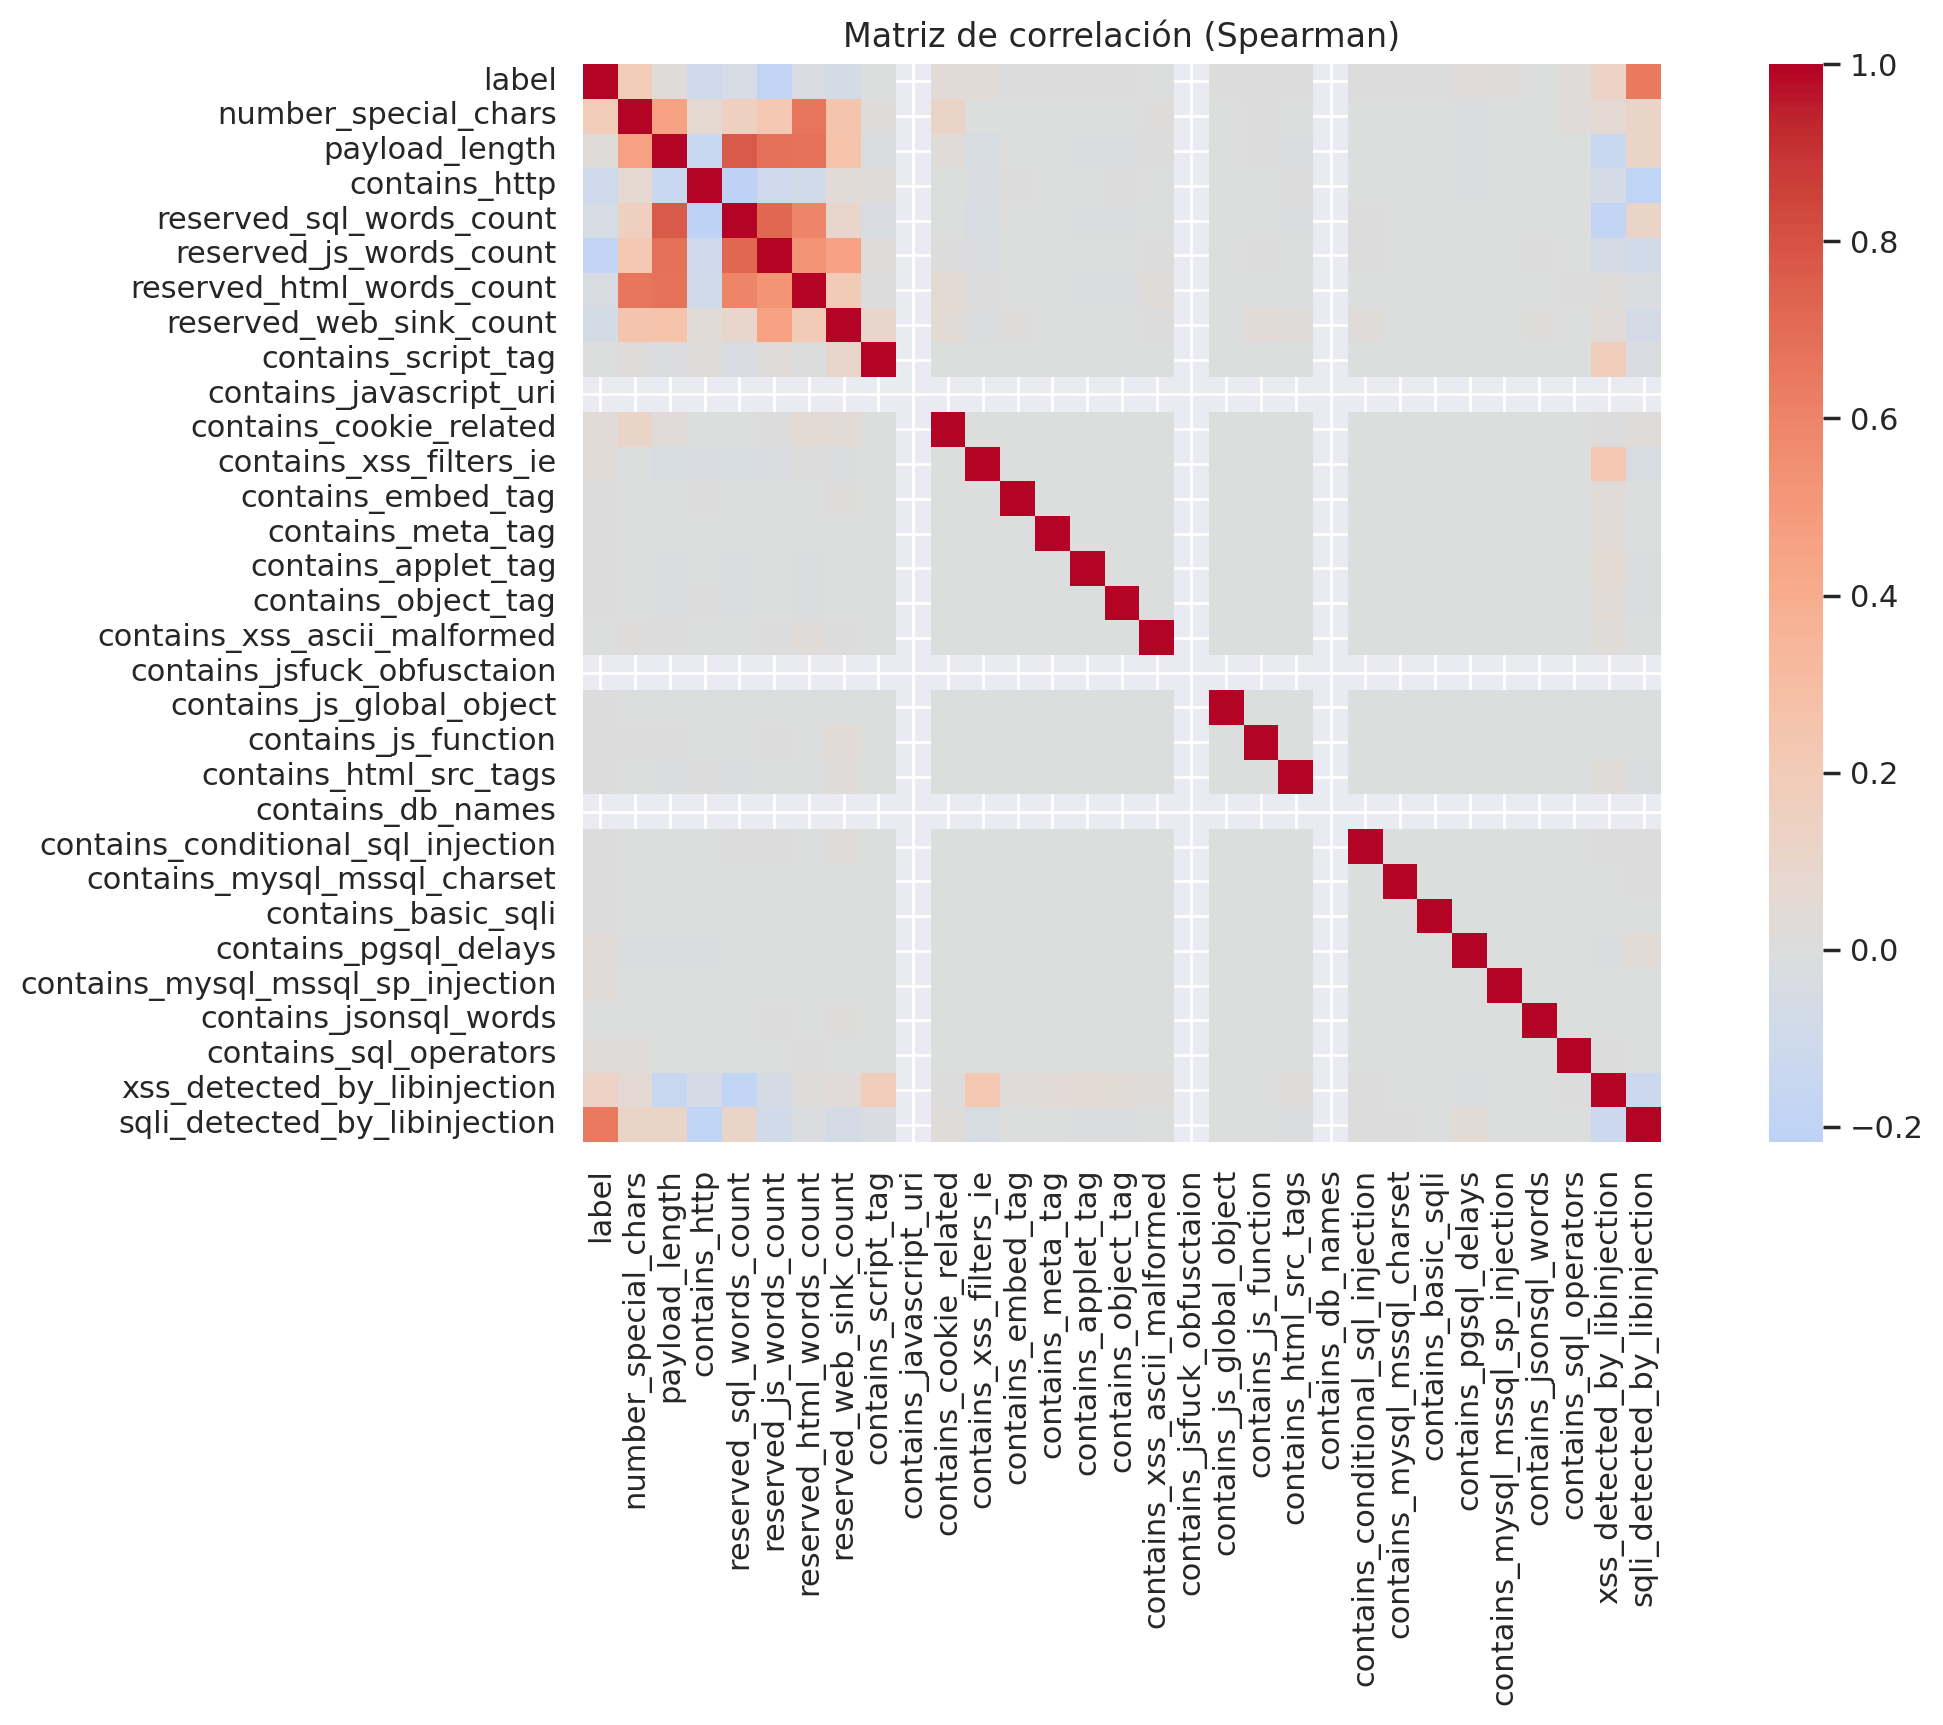

In [39]:
num_cols = df_xss_sqli_with_features.select_dtypes(include=[np.number, np.bool]).columns.tolist()

corr = df_xss_sqli_with_features[num_cols].corr(method="pearson")
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, square=True)

plt.title("Matriz de correlación")
plt.show()

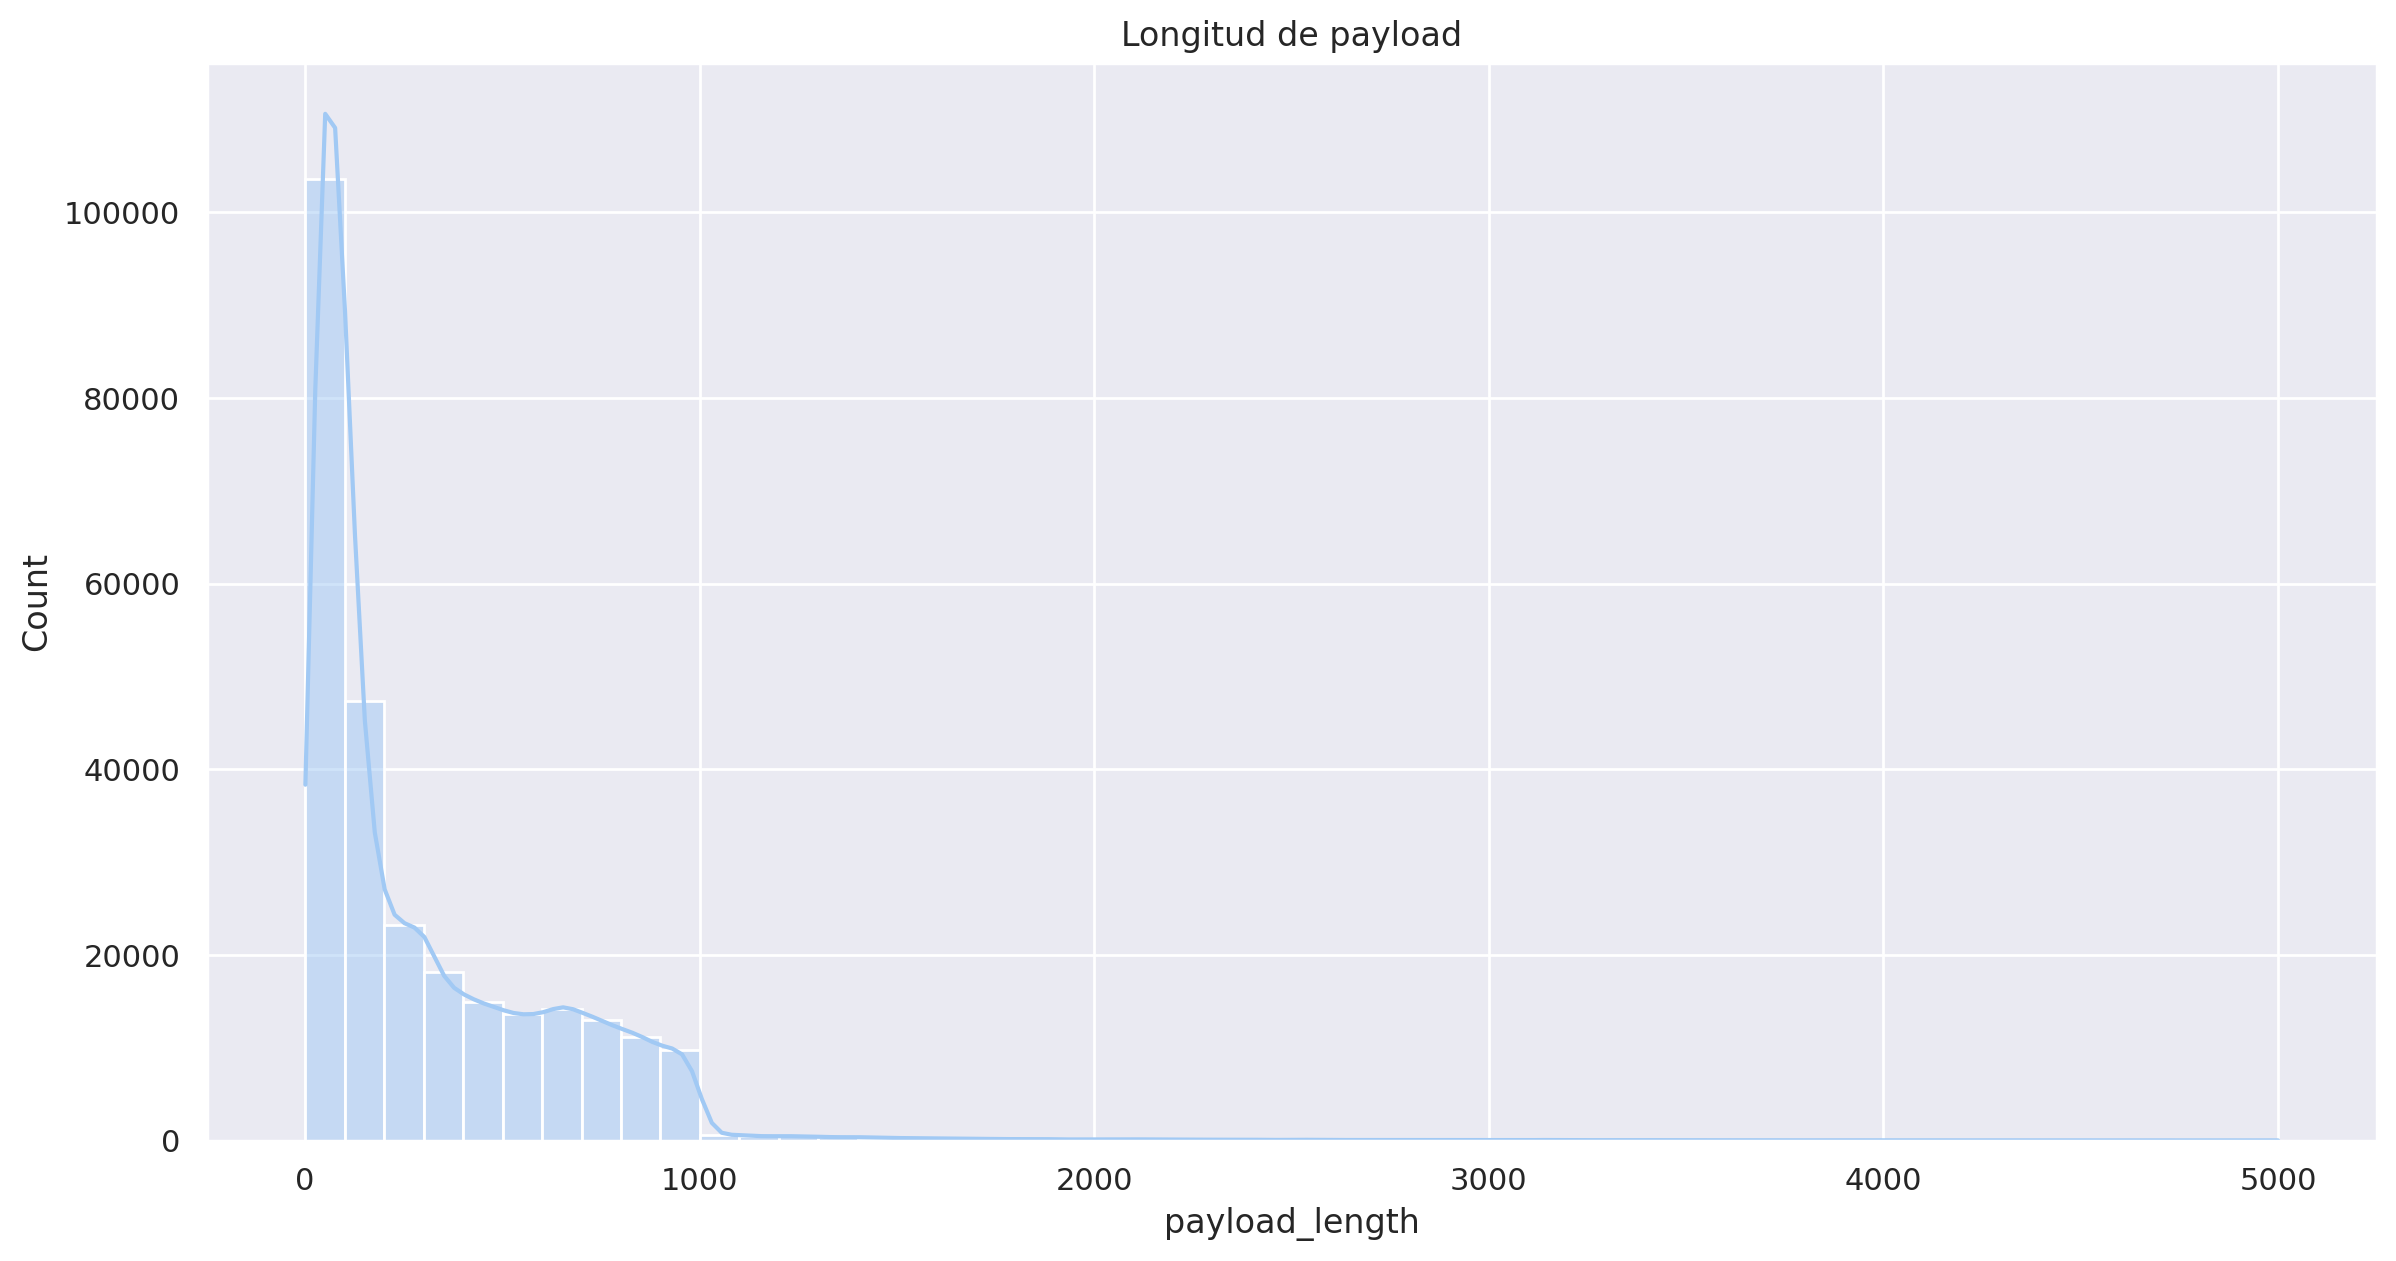

In [40]:
sns.histplot(data=df_xss_sqli_with_features, x="payload_length", bins=50, kde=True)
plt.title("Longitud de payload")
plt.show()

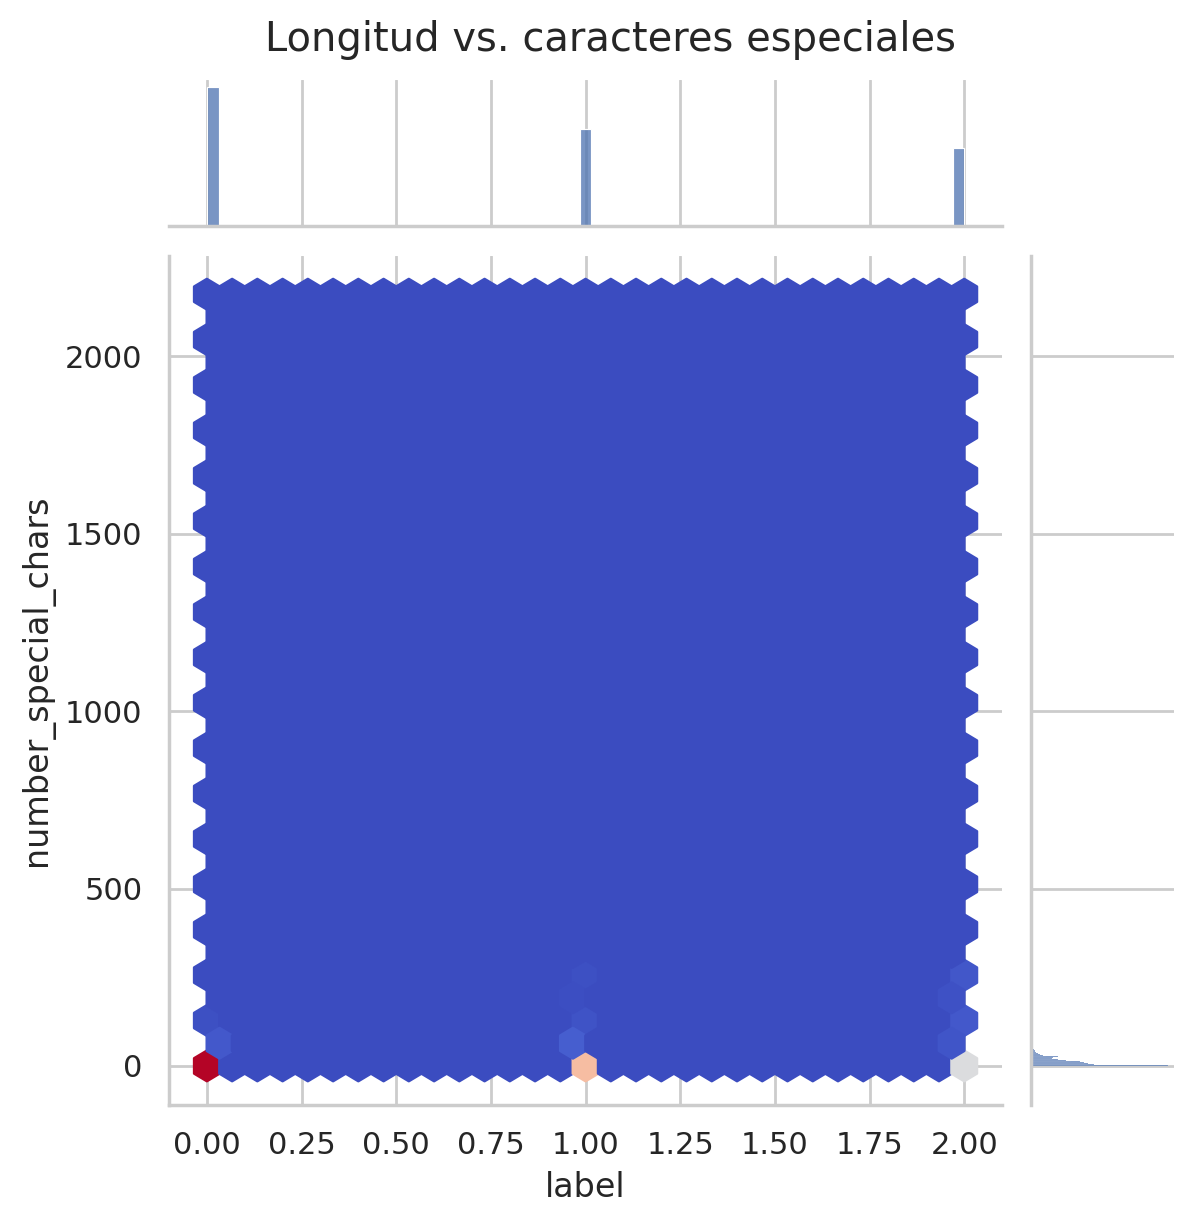

In [56]:
sns.jointplot(data=df_xss_sqli_with_features, x="label", y="number_special_chars", kind="hex", gridsize=30,
              cmap="coolwarm")
plt.suptitle("Longitud vs. caracteres especiales", y=1.02)
plt.show()

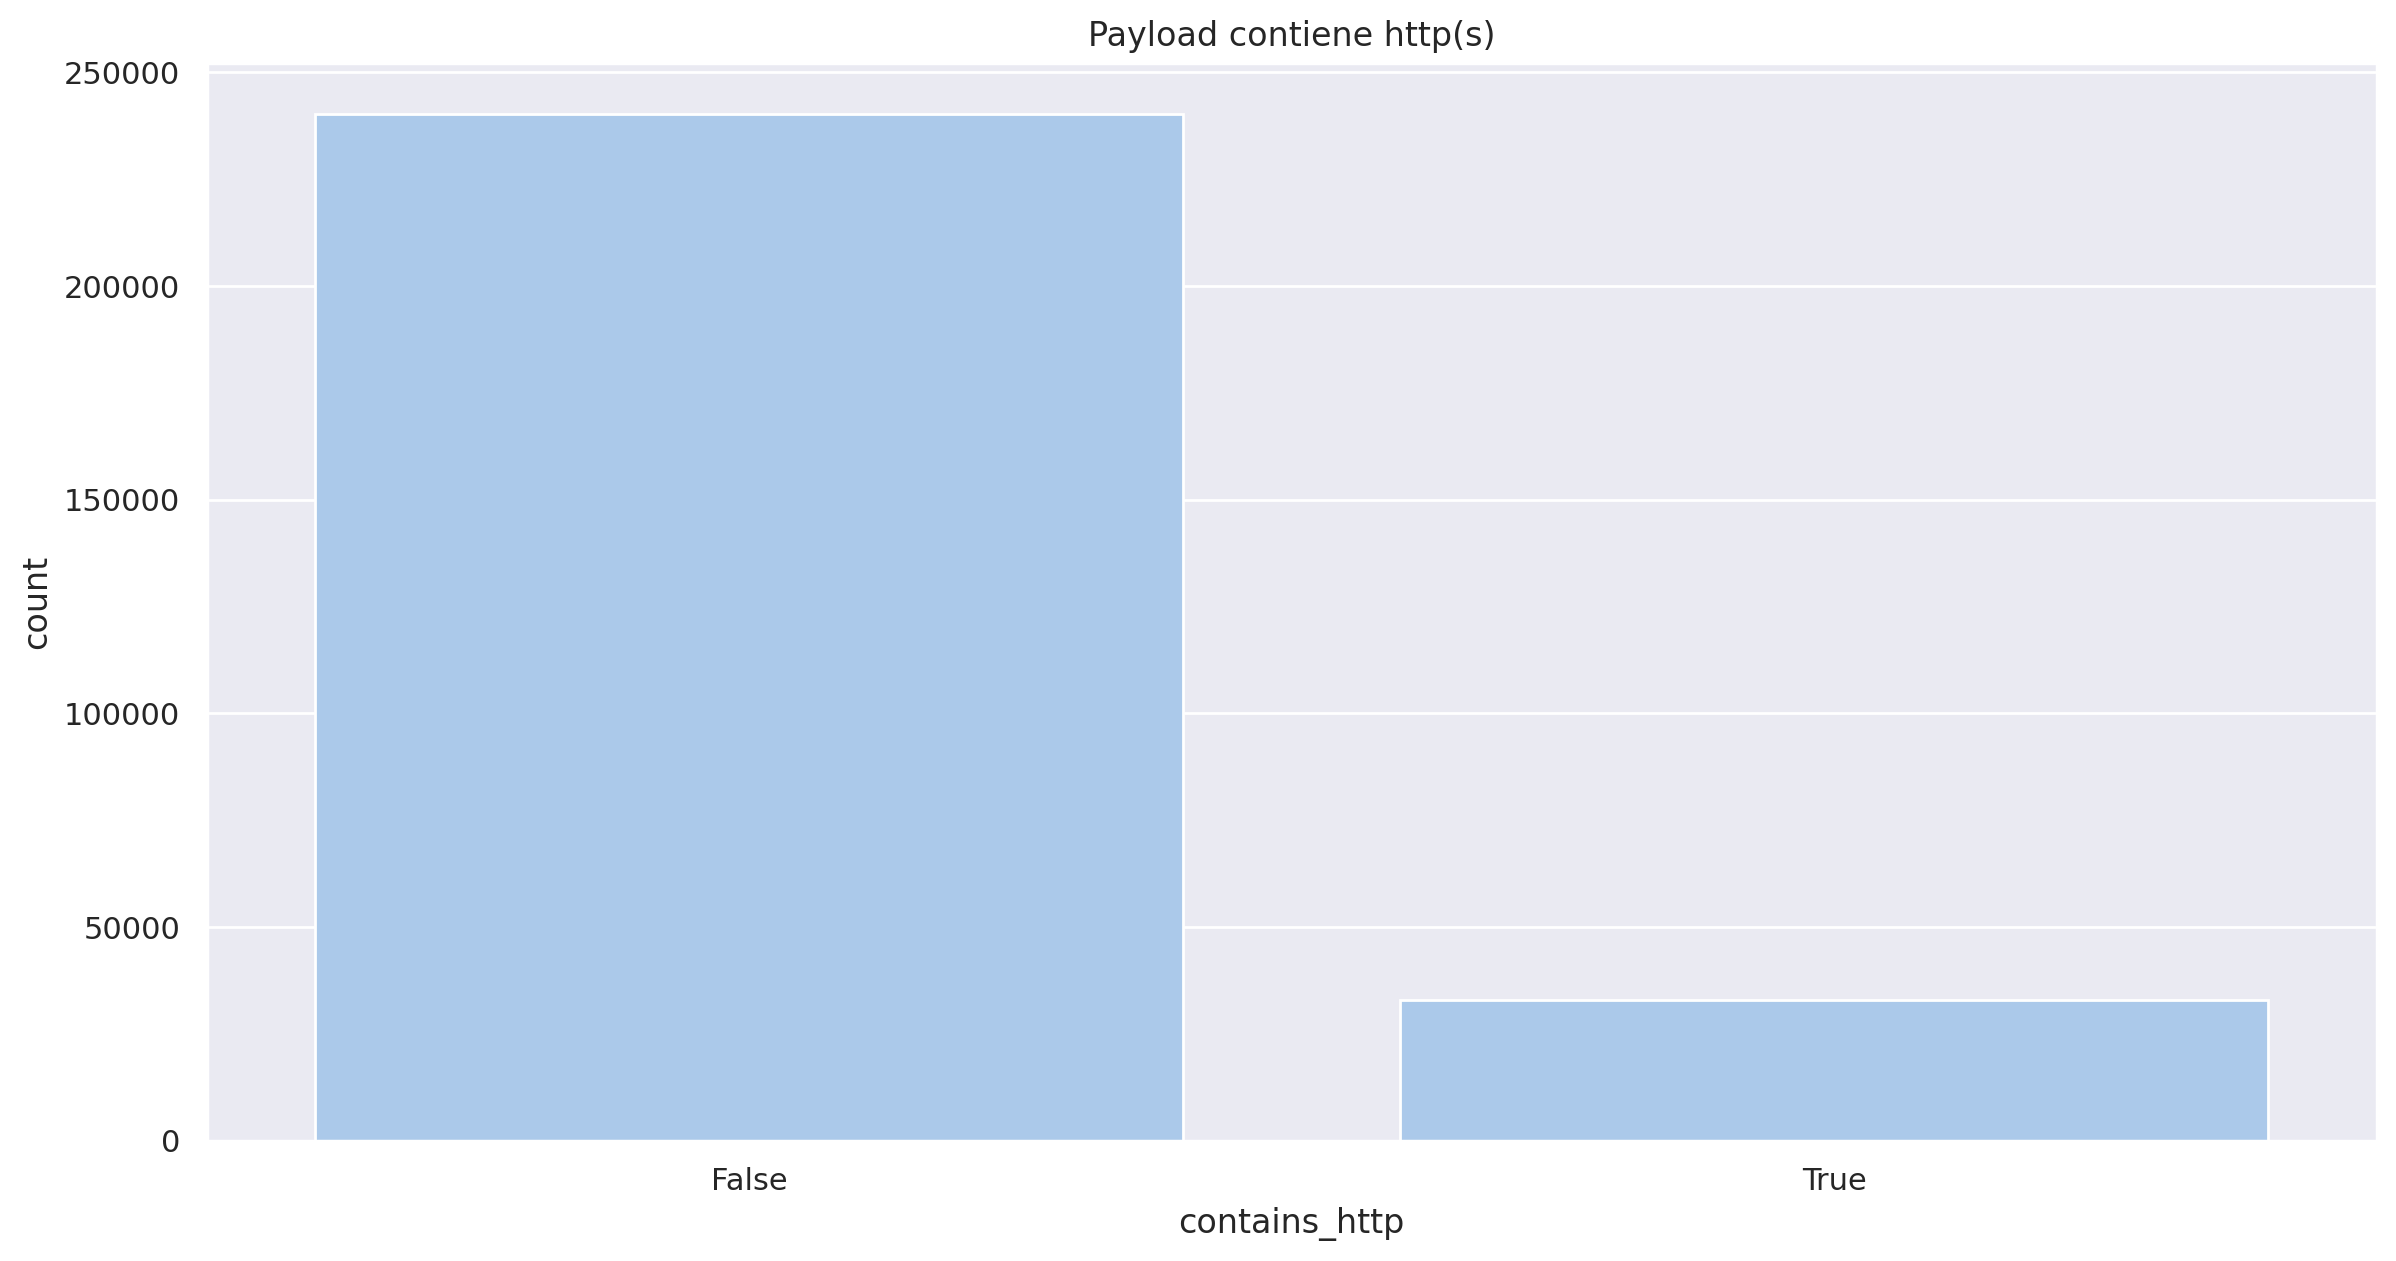

In [43]:
sns.countplot(data=df_xss_sqli_with_features, x="contains_http")
plt.title("Payload contiene http(s)")
plt.show()

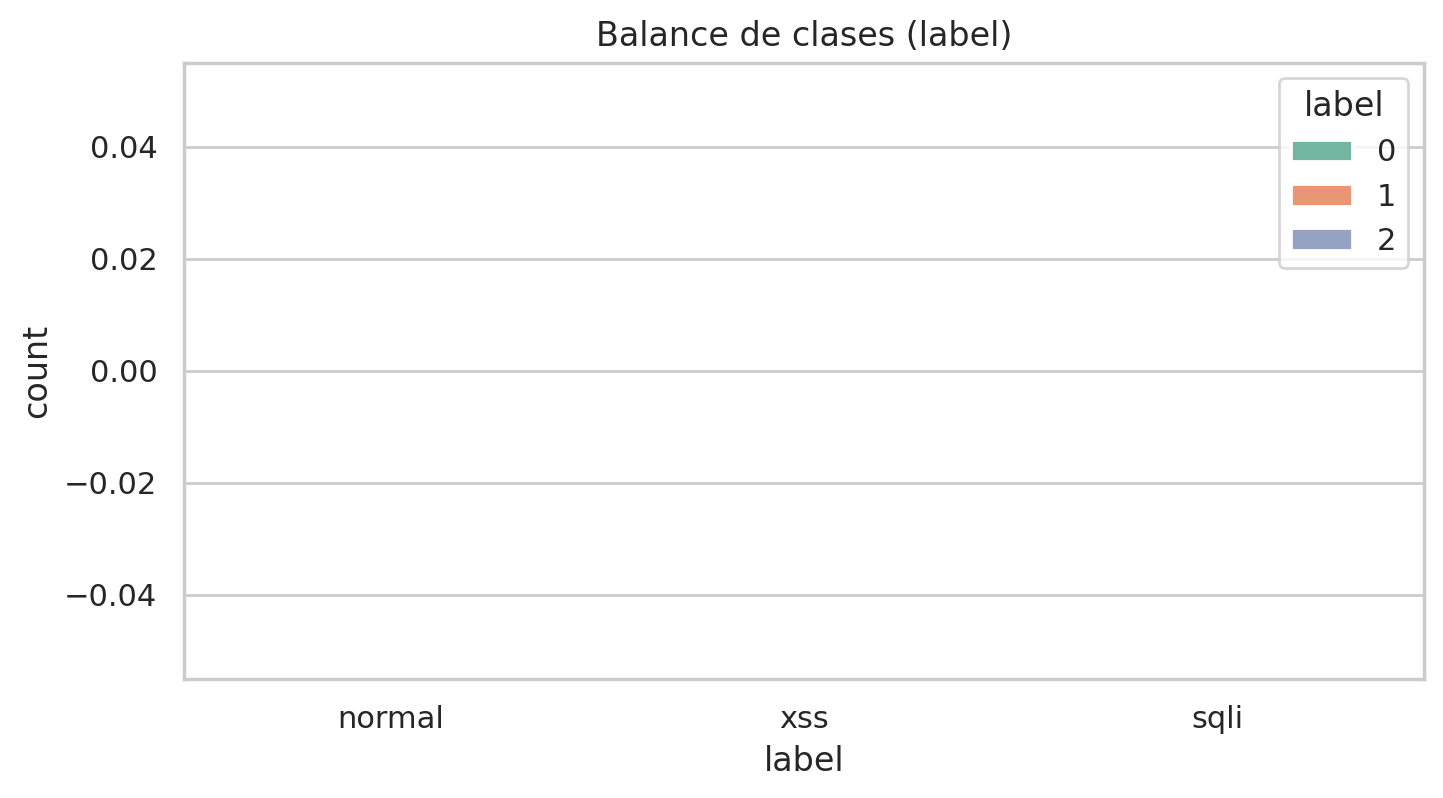

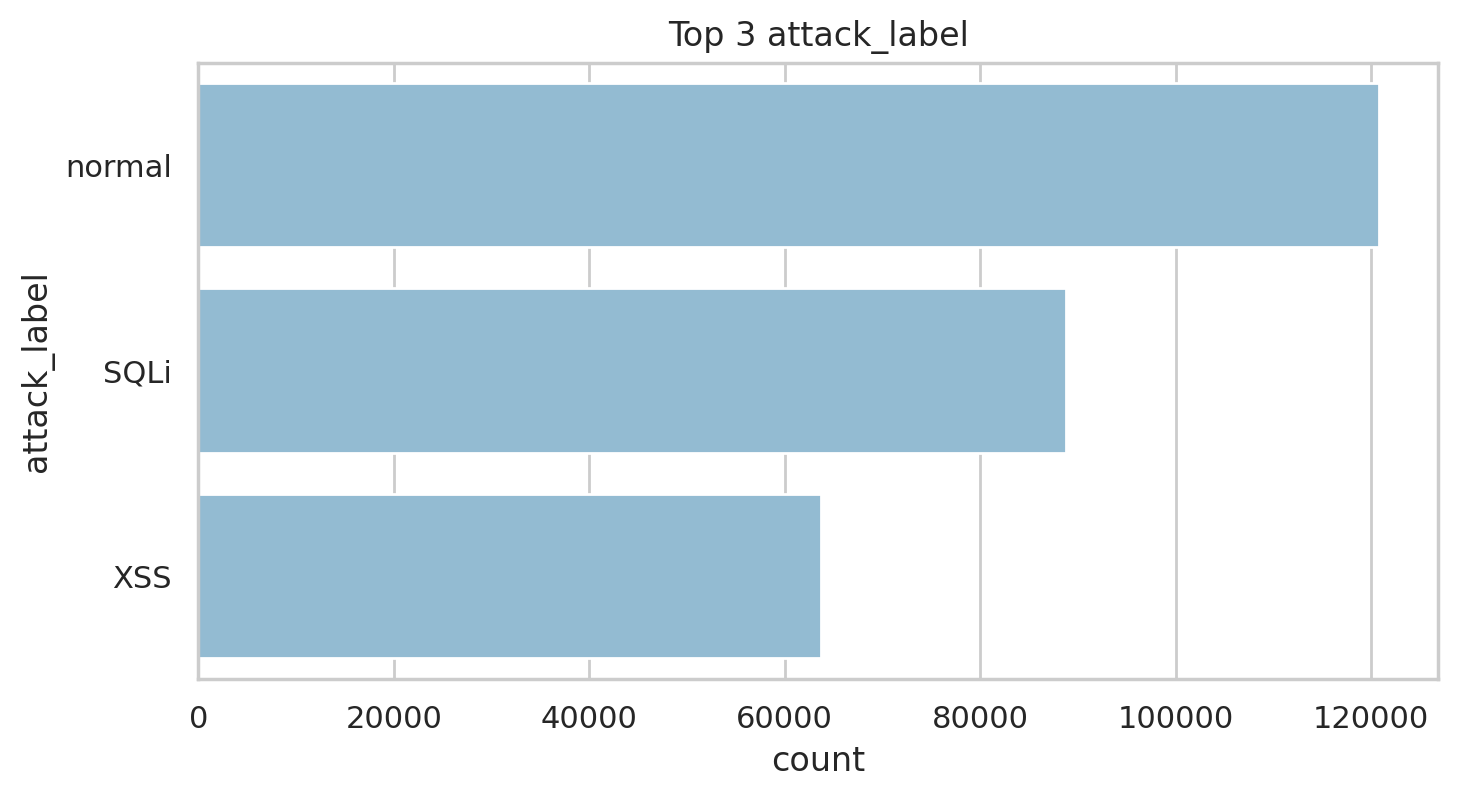

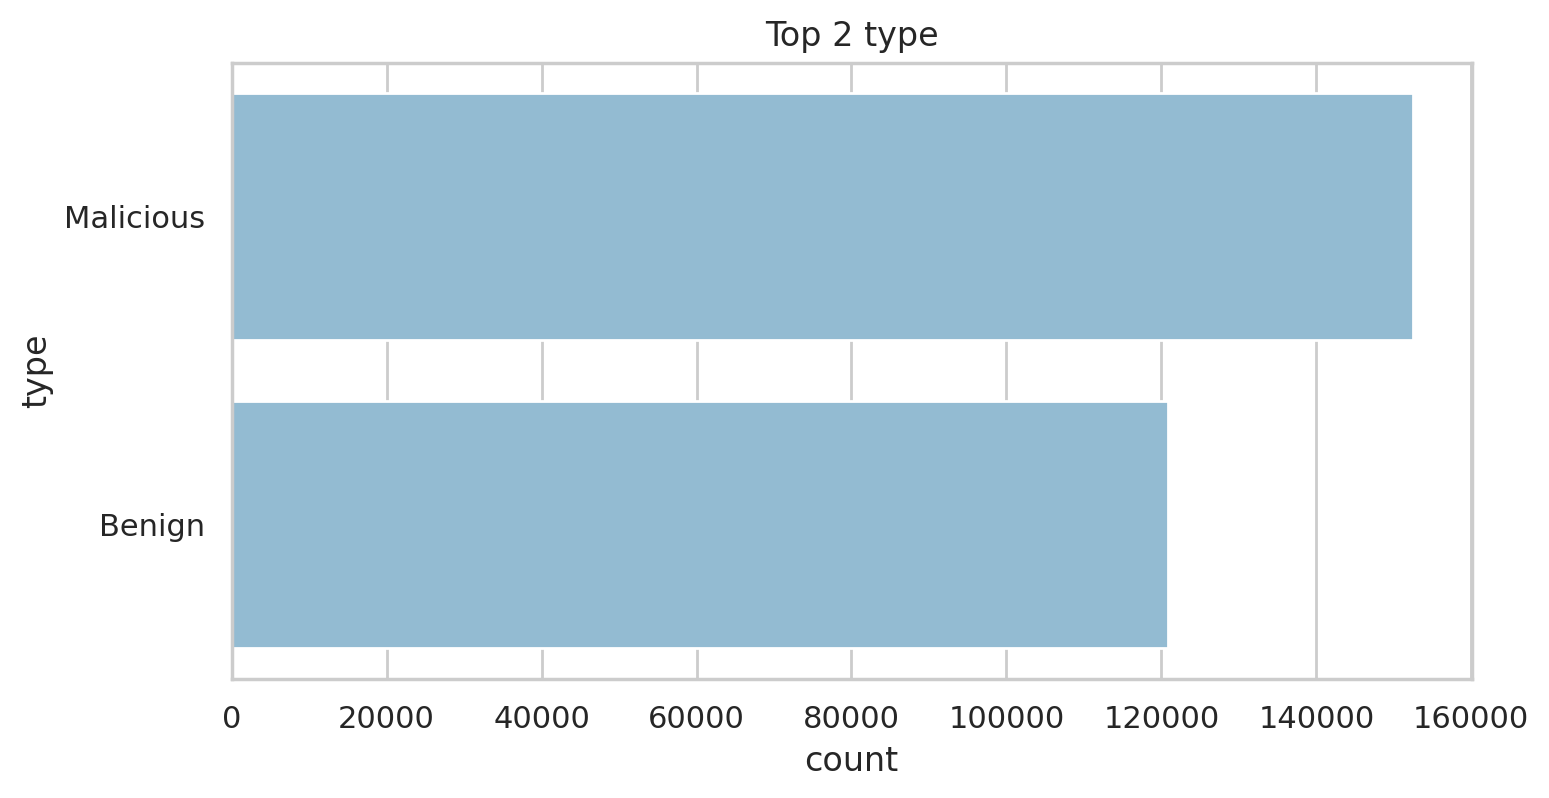

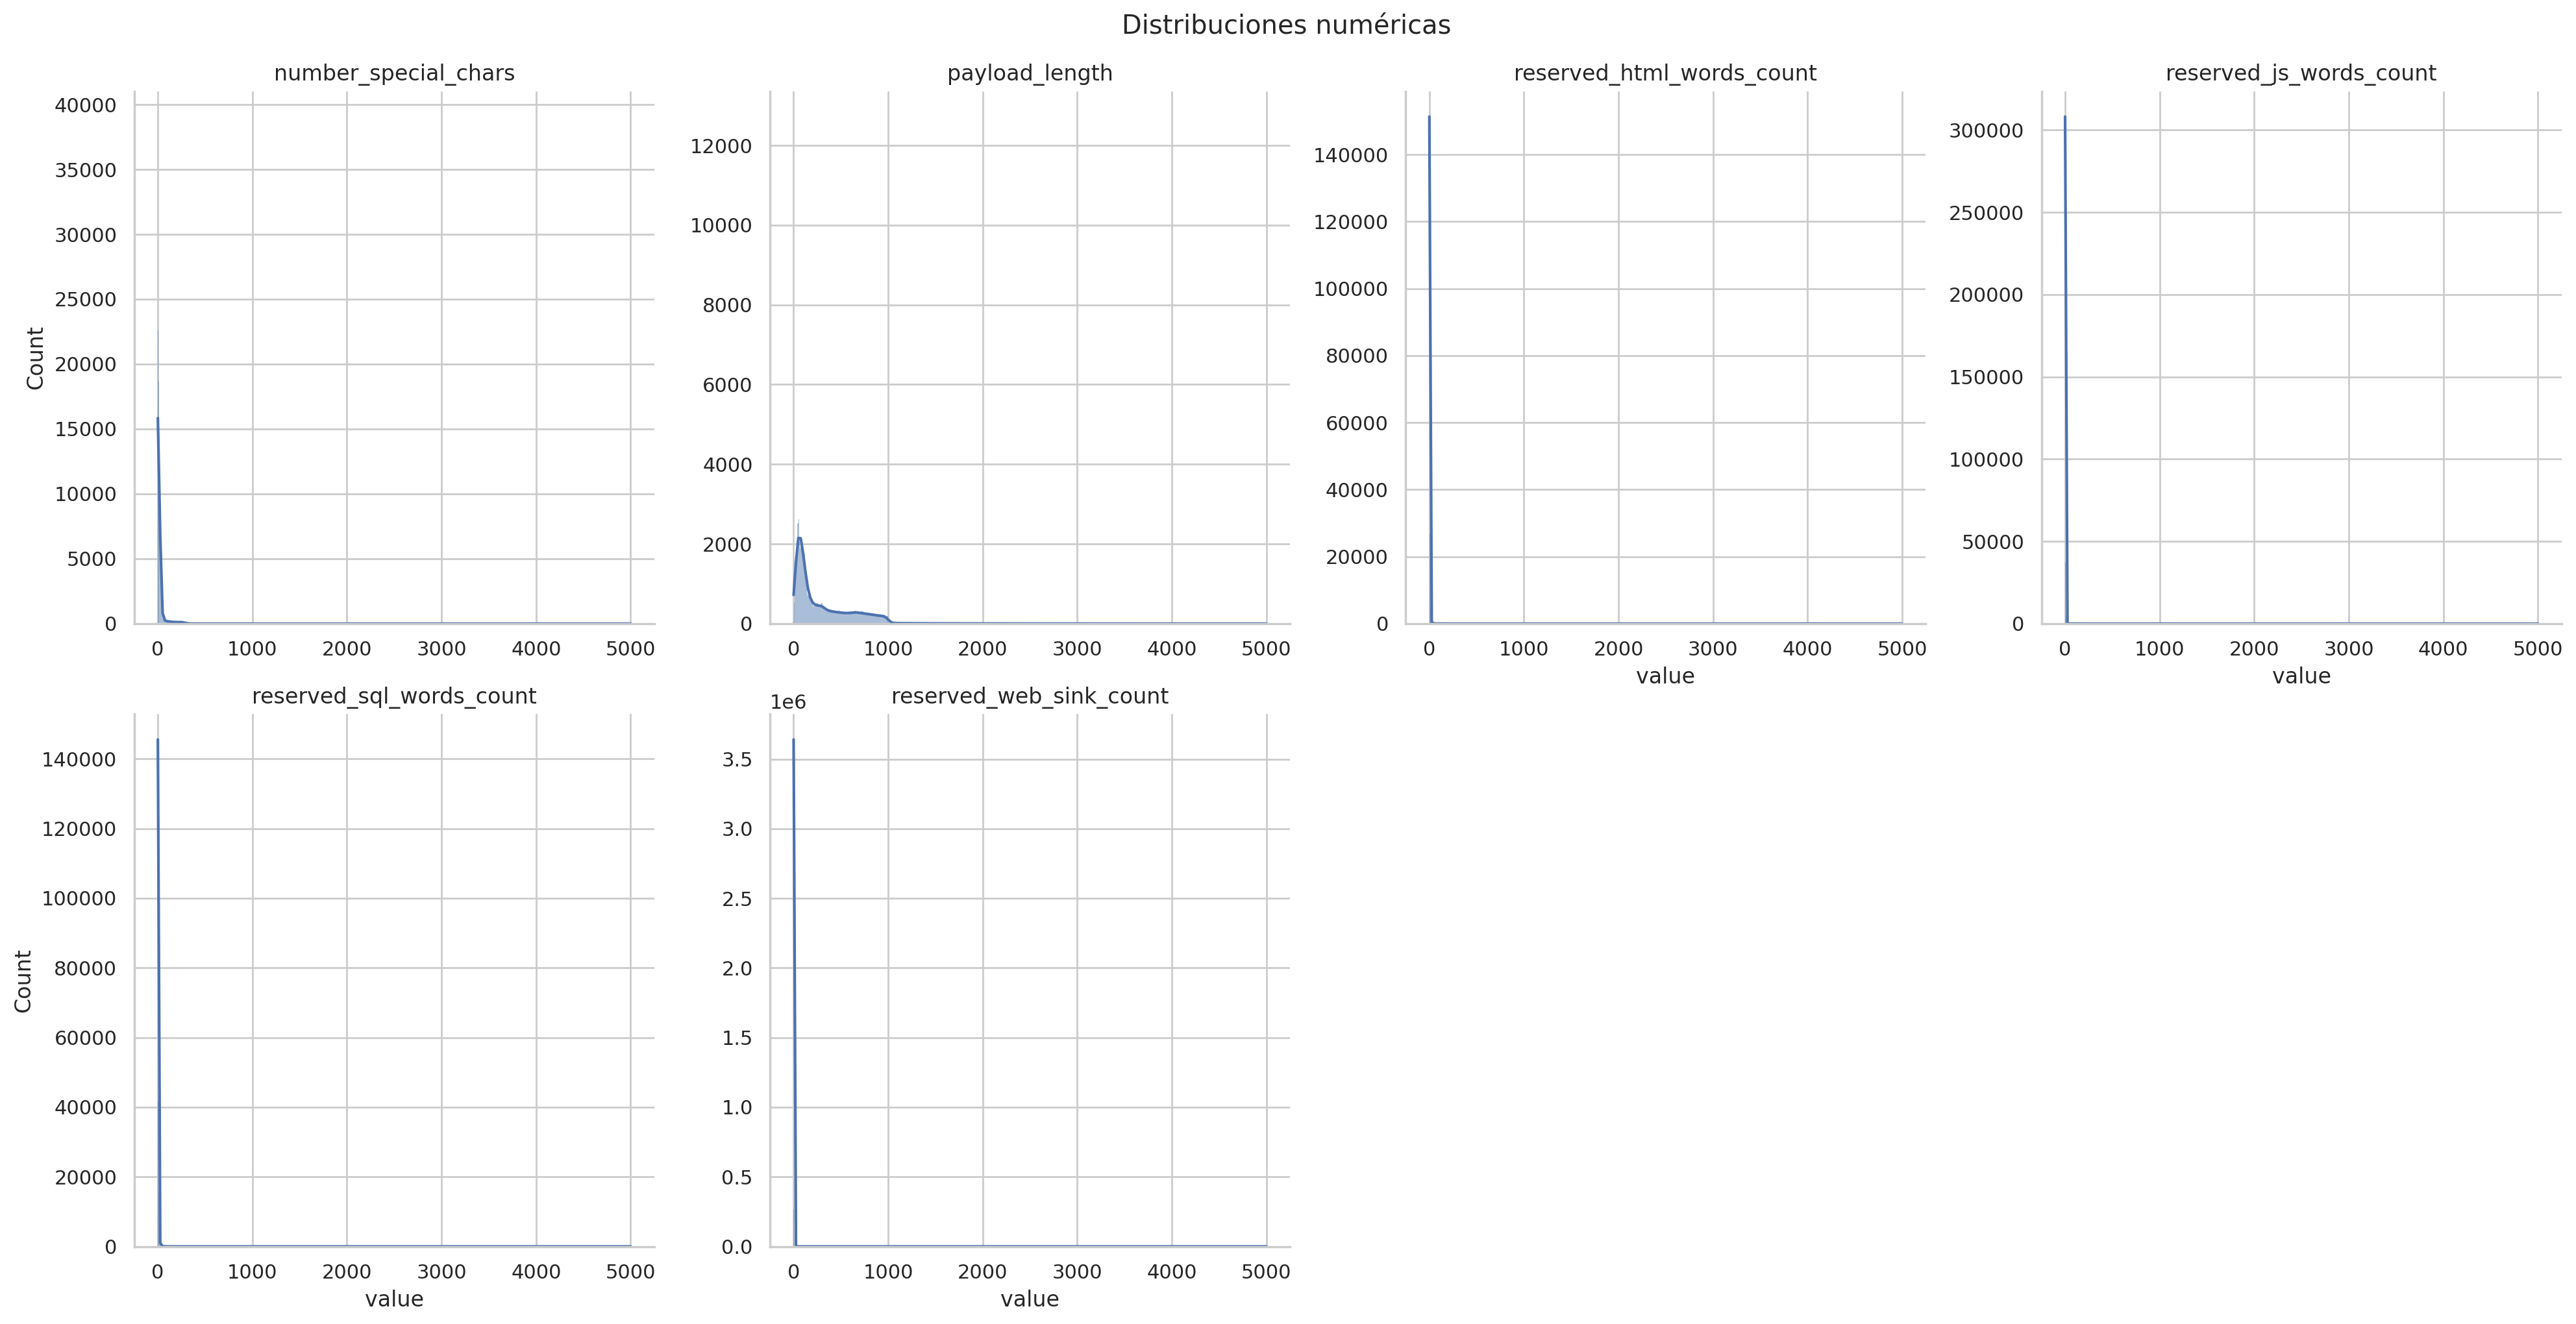

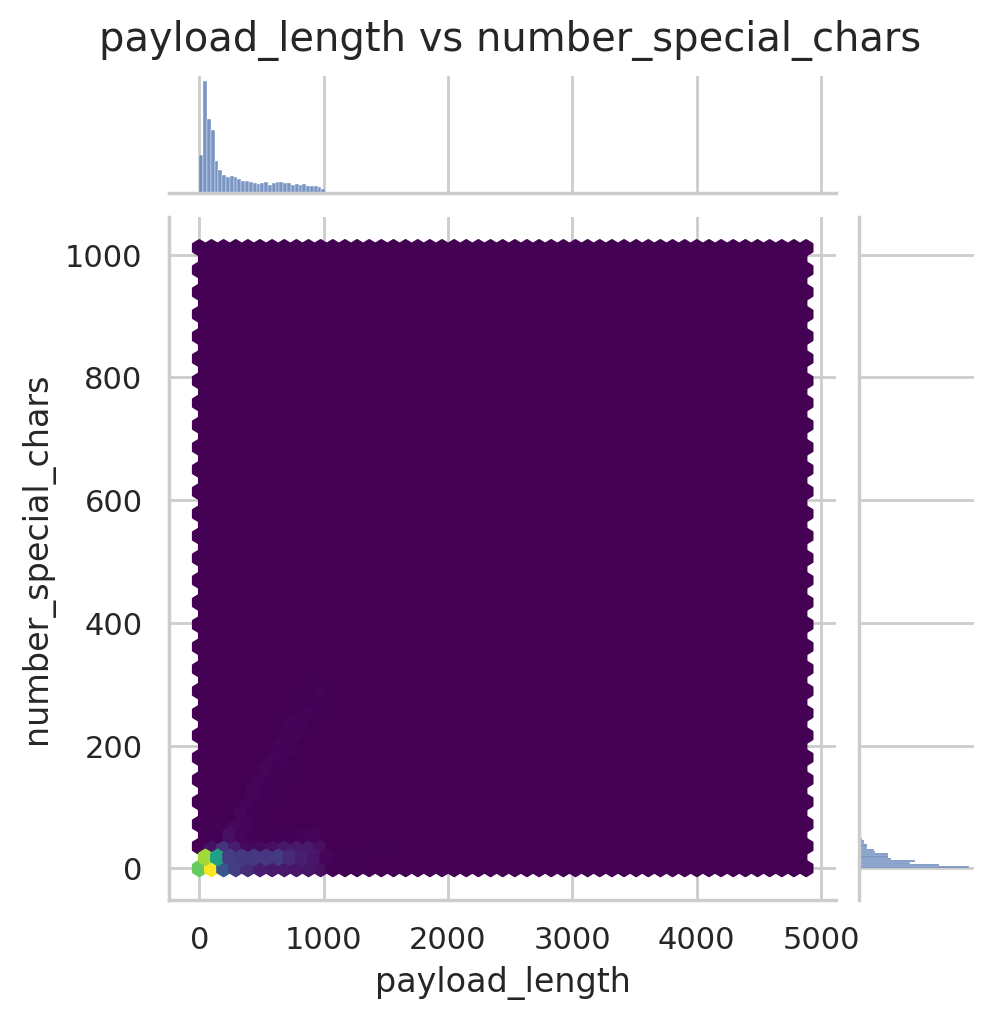

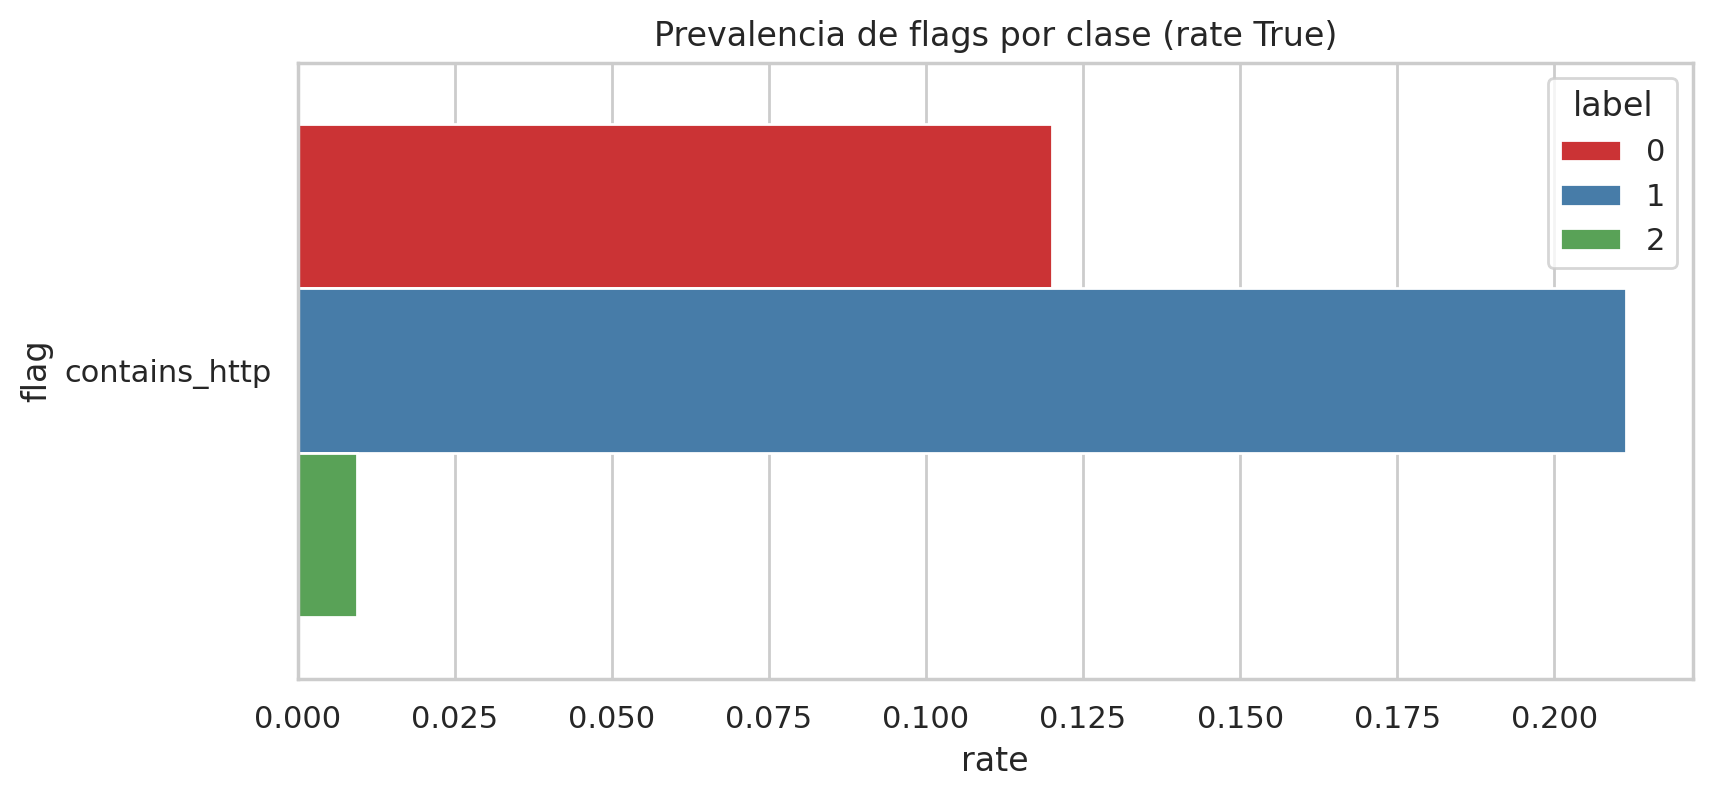

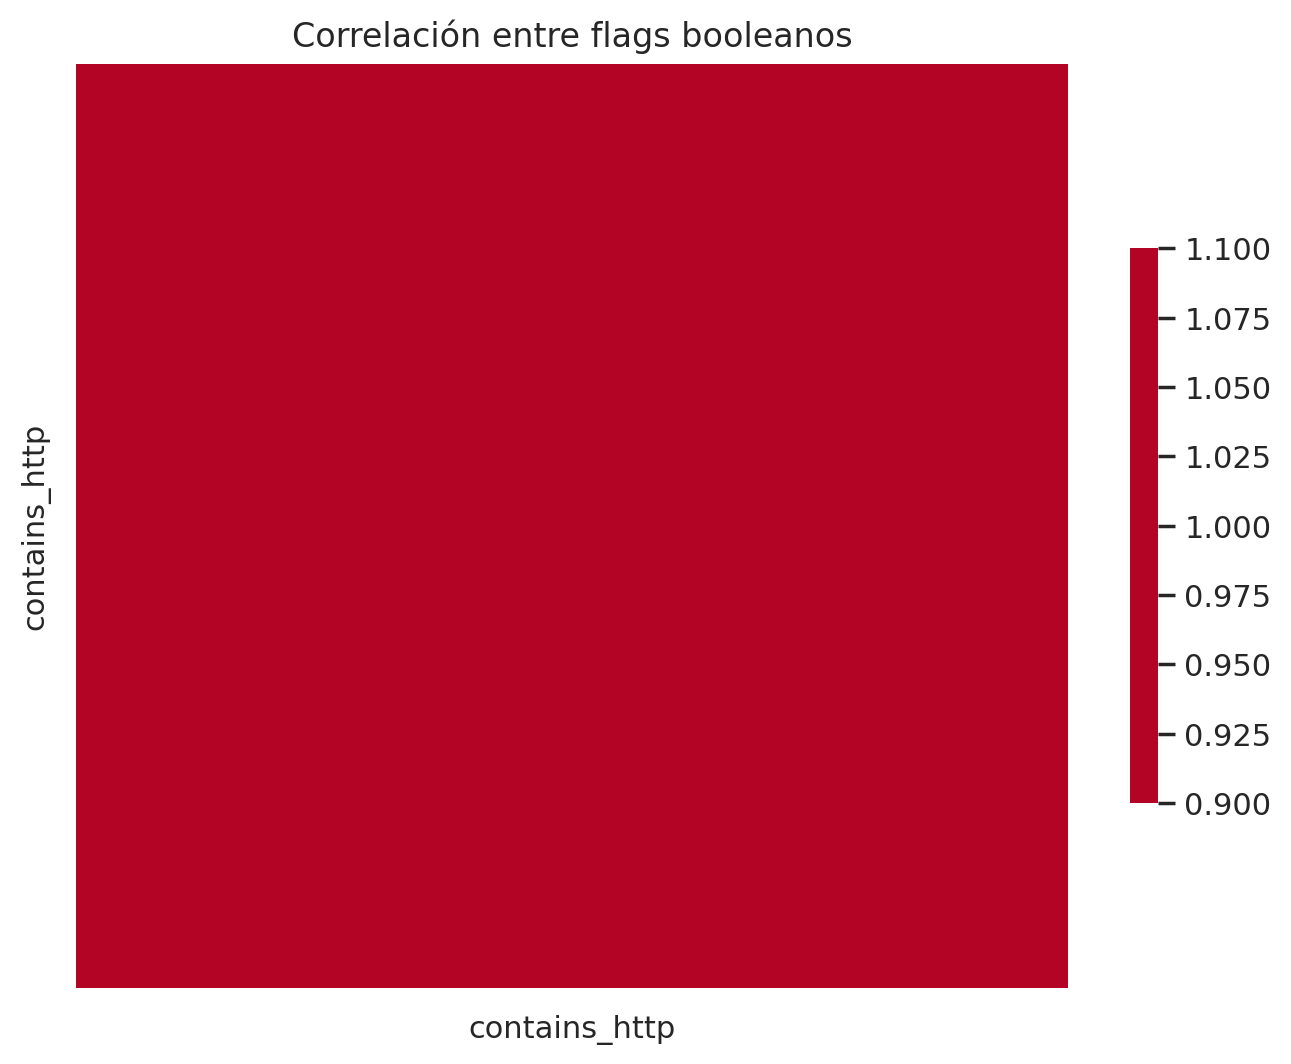

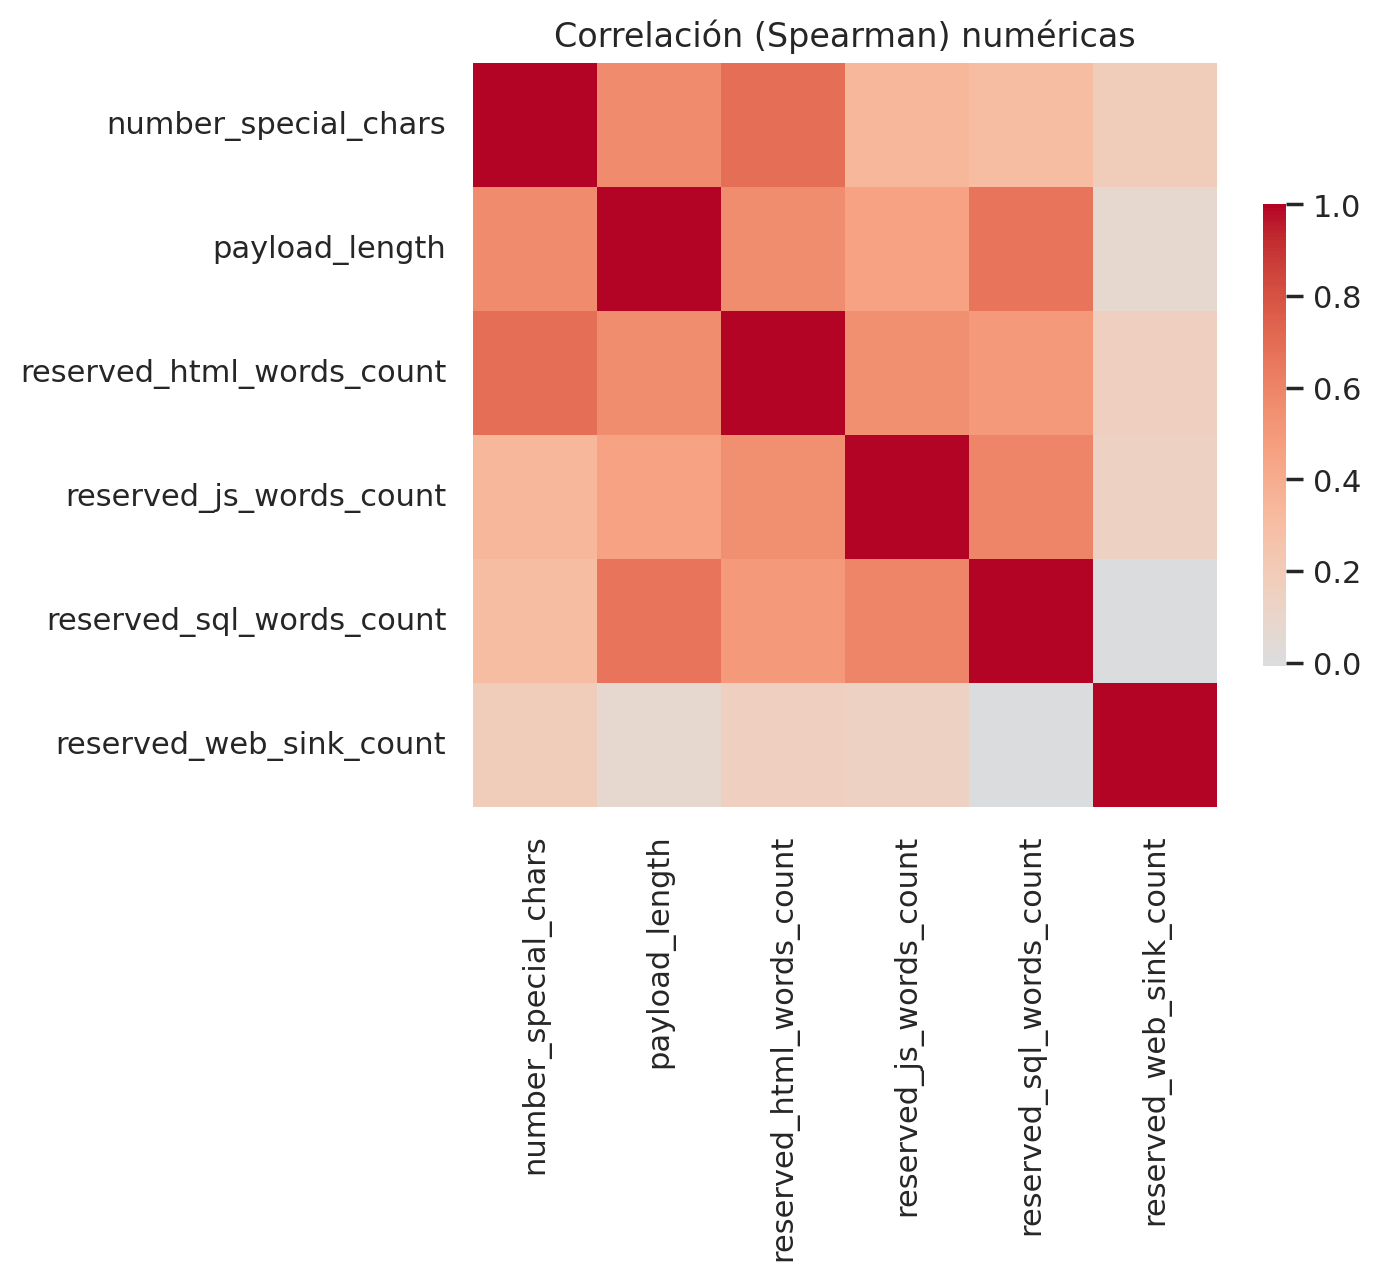

In [62]:
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8,4)

label_map = {0: "normal", 1: "xss", 2: "sqli"}
cat_order = [label_map[k] for k in sorted(label_map)]

df = df_xss_sqli_filtered.copy()

# --- 0) Helpers ---
def topn(s, n=20):
    c = s.value_counts(dropna=False)
    return c.iloc[:n]

def rate_true_by_label(df, cols_bool, label_col="label"):
    out = []
    for c in cols_bool:
        g = df.groupby(label_col)[c].mean().rename("rate").reset_index()
        g["feature"] = c
        out.append(g)
    return pd.concat(out, ignore_index=True)

# --- 1) Balance de clases y categorías ---
fig, ax = plt.subplots()

ax = sns.countplot(data=df, order=cat_order, x="label", hue="label", palette="Set2", ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title("Balance de clases (label)")
plt.show()

for cat in ["attack_label", "type"]:
    if cat in df.columns:
        vc = topn(df[cat], 25).reset_index()
        vc.columns = [cat, "count"]

        plt.figure()
        sns.barplot(
            data=vc, y=cat, x="count",
            color=sns.color_palette("Blues_r")[3]  # <- color único
        )
        plt.title(f"Top {len(vc)} {cat}")
        plt.xlabel("count"); plt.ylabel(cat)
        plt.show()

# --- 2) Distribuciones numéricas ---
num_cols = (
    df.select_dtypes(include=[np.number]).columns
    .difference(["label"])  # excluye la etiqueta
    .tolist()
)
if num_cols:
    long = df[num_cols].melt(var_name="feature", value_name="value")
    # FIX 3: en displot usa x="value" (no 'label="value"')
    g = sns.displot(data=long, x="value", col="feature", col_wrap=4, kde=True,
                    facet_kws=dict(sharex=False, sharey=False))
    g.set_titles("{col_name}")
    plt.suptitle("Distribuciones numéricas", y=1.02)
    plt.show()

# --- 3) Relación entre longitud y especialización ---
if {"payload_length","number_special_chars","label"}.issubset(df.columns):
    sample = df.sample(min(len(df), 20000), random_state=0)
    sns.jointplot(data=sample, x="payload_length", y="number_special_chars",
                  kind="hex", cmap="viridis", height=5)
    plt.suptitle("payload_length vs number_special_chars", y=1.02)
    plt.show()

# --- 4) Prevalencia de flags booleanos por clase ---
bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
if bool_cols:
    rates = rate_true_by_label(df, bool_cols, "label")
    pivot = rates.pivot(index="feature", columns="label", values="rate").fillna(0.0)
    pivot["lift"] = pivot.get(1,0) - pivot.get(0,0)
    order = pivot.sort_values("lift", ascending=False).index
    plt.figure(figsize=(9, max(4, len(bool_cols)*0.25)))
    sns.barplot(data=rates, y="feature", x="rate", hue="label", order=order, palette="Set1")
    plt.title("Prevalencia de flags por clase (rate True)")
    plt.xlabel("rate"); plt.ylabel("flag")
    plt.show()

# --- 5) Correlación entre flags (phi) y entre numéricas ---
if bool_cols:
    bool_as_int = df[bool_cols].astype("int8")
    corr_bool = bool_as_int.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_bool, cmap="coolwarm", center=0, square=False, cbar_kws={"shrink":.6})
    plt.title("Correlación entre flags booleanos")
    plt.show()

if num_cols:
    corr_num = df[num_cols].corr(method="spearman", numeric_only=True)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_num, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink":.6})
    plt.title("Correlación (Spearman) numéricas")
    plt.show()
